### Saurabh Manral
### A19028
### TXTA Question 1

# Scraping the Data

In [159]:
#Loading essential libraries

import pandas as pd
import numpy as np
import os, re
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [243]:
#Loading NLP libraries

import io
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

import nltk
import textwrap

from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import RegexpTokenizer

from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
#Providing the path to folder

folder_path='C:/Users/manra/OneDrive/Desktop/Obama speeches pdf/'

In [3]:
#Getting file names

files= os.listdir(folder_path)

In [4]:
#Defining functions to extract text:
# 1. "extract_text_by_page" function reads the text from pdf page by page
# 2. "extract_text" function uses the previous function to return all the text from document 

def extract_text_by_page(pdf_path):
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            resource_manager = PDFResourceManager()
            fake_file_handle = io.StringIO()
            converter = TextConverter(resource_manager, fake_file_handle)
            page_interpreter = PDFPageInterpreter(resource_manager, converter)
            page_interpreter.process_page(page)
            
            text = fake_file_handle.getvalue()
            yield text
    
            # close open handles
            converter.close()
            fake_file_handle.close()
    
def extract_text(pdf_path):
    l=[]
    for page in extract_text_by_page(pdf_path):
        l.append(page)
        
    return ''.join(l)

**Trying these functions on single PDF document :**

In [5]:
pdf1=extract_text('C:/Users/manra/OneDrive/Desktop/Obama speeches pdf/01 Apr 2016_Barack Obama - Nuclear Security Summit Presser.pdf')

In [133]:
print(textwrap.shorten(pdf1,500))

AAmmeerriiccaannRRhheettoorriicc..ccoomm AmericanRhetoric.com Page 1 Barack Obama Nuclear Security Summit Press Conference delivered 1 April 2016, Walter E. Washington Convention Center, Washington, D.C. AUTHENTICITY CERTIFIED: Text version below transcribed directly from audio Good evening, everybody. I want to begin by thanking the people of Washington, D.C. for hosting us, especially for putting up with more than 50 motorcades. And I will make one promise to the people of this city -- I [...]


**Now we try to extract Topic and Date of the speech from the file name :**

In [135]:
#Using 11th PDF name

files[10]

'01 May 2010_Barack Obama - White House Correspondents Dinner 2010.pdf'

In [152]:
#Let's extract only the topic

topic=re.findall('[A-Za-z - ]+',files[10])
topic[2]

' White House Correspondents Dinner '

In [150]:
#Let's extract only the date

date=re.findall('[0-9 A-Za-z 0-9]+',files[101])
date[0]

'08 Nov 2010'

In [151]:
#Now lets make a dataframe from all the info that we scraped:
#1. Date of Speech
#2. Heading of the Speech
#3. Content of the PDF Documents

data={'date':[],'header':[], 'content':[]}

folder_path='C:/Users/manra/OneDrive/Desktop/Obama speeches pdf'

l=[]
for i in files:
    head=re.findall('[A-Za-z - ]+',i)
    data['header'].append(head[2])
    
    date=re.findall('[0-9 A-Za-z 0-9]+',i)
    data['date'].append(date[0])
    
    content=extract_text(folder_path+'/'+i)
    data['content'].append(content)

In [161]:
#Lets make this into a DataFrame, and convert date to a python datetime object such that:
data=pd.DataFrame(data)
data['date']= pd.to_datetime(data['date'])
data.head()

,date,header,content
0,2016-04-01,Nuclear Security Summit Presser,AAmmeerriiccaannRRhheettoorriicc..ccoomm A...
1,2014-08-01,Presser on the Economy and Foreign Policy,AAmmeerriiccaannRRhheettoorriicc..ccoomm A...
2,2008-12-01,Security Team Announcement,AAmmeerriiccaannRRhheettoorriicc..ccoomm A...
3,2009-12-01,Afghanistan War Troop Surge,AAmmeerriiccaannRRhheettoorriicc..ccoomm P...
4,2015-12-01,Paris Press Conference,AAmmeerriiccaannRRhheettoorriicc..ccoomm A...


**Lets process the data to remove the introductory line "AAmmeerriiccaannRRhheettoorriicc.." from the content of PDFs**

In [163]:
#Well tokenise the strings of the content column and then remove the intro using python regular expressions

speech=[]
for i in data['content']:
    
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    sent_detector._params.abbrev_types.add('hon')
    
    tokens=sent_detector.tokenize(i)
    
    speech.append(re.sub(tokens[0],'',i))

In [164]:
#We'll use a new column 'speech' instead of content

data['speech']=speech
data.drop('content',axis=1,inplace=True)
data.head()

,date,header,speech
0,2016-04-01,Nuclear Security Summit Presser,I want to begin by thanking the people of Wa...
1,2014-08-01,Presser on the Economy and Foreign Policy,Happy Friday. I thought I’d take some quest...
2,2008-12-01,Security Team Announcement,I hope you all had a wonderful Thanksgiving. ...
3,2009-12-01,Afghanistan War Troop Surge,All rights reserved. Page 1 Barack Obama ...
4,2015-12-01,Paris Press Conference,"Once again, I want to thank the people of Fr..."


**Our new Dataframe has much more processed data to be used for analysis. Now, we'll use the following analysis on the dataset:**

# World Cloud

In [165]:
#Using the RegexpTokeniser from NLTK library

tokenizer= RegexpTokenizer('[a-z]+')

In [166]:
token= [tokenizer.tokenize(x.lower()) for x in data['speech']]

#tokens is a list of all words in content 

In [167]:
#This is the list of lists of all the words in all the PDFs

len(token)

431

In [168]:
#Removing stop words from our vocabulary

tokens_no_stopwords=[t for x in token for t in x if t not in STOPWORDS]

In [169]:
#List containing all non-stop words

len(tokens_no_stopwords)

785553

In [170]:
#Let us extract the frequency of the words used by Obama in his speeches, and find wich words or phrases are most common:

word_count= Counter(tokens_no_stopwords)
word_count.most_common(10)

[('s', 17955),
 ('people', 7306),
 ('will', 7210),
 ('t', 6940),
 ('re', 6387),
 ('ve', 6249),
 ('going', 4563),
 ('us', 4539),
 ('president', 4268),
 ('now', 4019)]

**Some of the most frequent words, that we can make out are:**

**1. people**

**2. will**

**3. going**

**4. us**

**5. president**

**6. now**

In [393]:
wc= WordCloud(background_color='white')

In [394]:
wc.generate_from_frequencies(word_count)

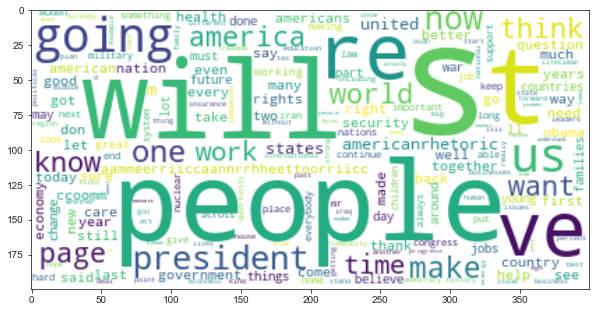

In [395]:
plt.figure(figsize=(10,8))
plt.imshow(wc,interpolation="bilinear")
plt.show()

# Sentiment Analysis

In [173]:
#We'll use NLTK's vader Sentiment Intensity Analyzer to find the sentiment score of Obama's speeches.
#The sentiment analyser gives us intensity of positive, negative or neutral elements in a speech and a composite score.

sid=SentimentIntensityAnalyzer()

a= data['speech'][1]
dick=sid.polarity_scores(a)
dick

{'neg': 0.084, 'neu': 0.781, 'pos': 0.135, 'compound': 0.9999}

In [174]:
#Defining a function to calculate the sentiment intensity of a speech and return the compound score

def sentiment_score(speech):
    dic=sid.polarity_scores(speech)
    return dic['compound']

In [175]:
#We'll add these scores to a new column in our DataFrame

data['sentiment score']= data['speech'].apply(sentiment_score)
data.head()

,date,header,speech,sentiment score
0,2016-04-01,Nuclear Security Summit Presser,I want to begin by thanking the people of Wa...,0.9999
1,2014-08-01,Presser on the Economy and Foreign Policy,Happy Friday. I thought I’d take some quest...,0.9999
2,2008-12-01,Security Team Announcement,I hope you all had a wonderful Thanksgiving. ...,0.9974
3,2009-12-01,Afghanistan War Troop Surge,All rights reserved. Page 1 Barack Obama ...,0.9979
4,2015-12-01,Paris Press Conference,"Once again, I want to thank the people of Fr...",1.0000


In [176]:
#Now we'll define a fucntion to add Labels to a speech, and roughly classify it as positive, negative or neutral

def sentiment(score):
    if  -1<= score <=-.25:
        return 'Negative'
    elif -.25<= score <=.25:
        return 'Neutral'
    else:
        return 'Positive'        

In [177]:
#Applying the function and previewing random data

data['sentiment of speech']= data['sentiment score'].apply(sentiment)
data.iloc[200:210,:]

,date,header,speech,sentiment score,sentiment of speech
200,2015-10-15,Afghanistan Statement,Last December -- more than 13 years after ou...,0.9996,Positive
201,2013-04-16,Boston Marathon Bombing Second Statement,I've just been briefed by my national securi...,0.9102,Positive
202,2012-12-16,Newtown Vigil Address,"To all the families, first responders, to the...",0.9998,Positive
203,2016-12-16,Final Presidential Presser,This is the most wonderful press conference ...,1.0000,Positive
204,2016-02-16,ASEAN Summit,Let me begin by thanking the Annenberg Found...,1.0000,Positive
205,2007-01-16,Candidate Exploratory Announcement,Copyright Status: Unknown Page 1 Barack Obama...,0.9658,Positive
206,2013-01-16,Gun Violence Exec Order,"Please -- Please have a seat. Good afternoon,...",-0.9980,Negative
207,2017-01-16,Chicago Cubs WH Visit,"Now, I know you guys would prefer to stand th...",0.9999,Positive
208,2010-06-16,Nurses Association,"All right, everybody have a seat. I got a l...",0.9997,Positive
209,2016-06-16,Orlando Community,"Today, we are reminded of what is good. That...",-0.8339,Negative


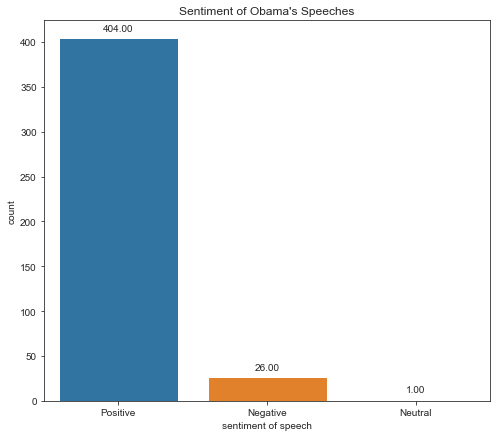

In [178]:
#We can visualise the number of speeches made by Obama and to what classes they belong to:

sns.set_style('ticks')

plt.figure(figsize=(8,7))
plt.title("Sentiment of Obama's Speeches")
chart=sns.countplot(data=data,x='sentiment of speech',)

for p in chart.patches:
    chart.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

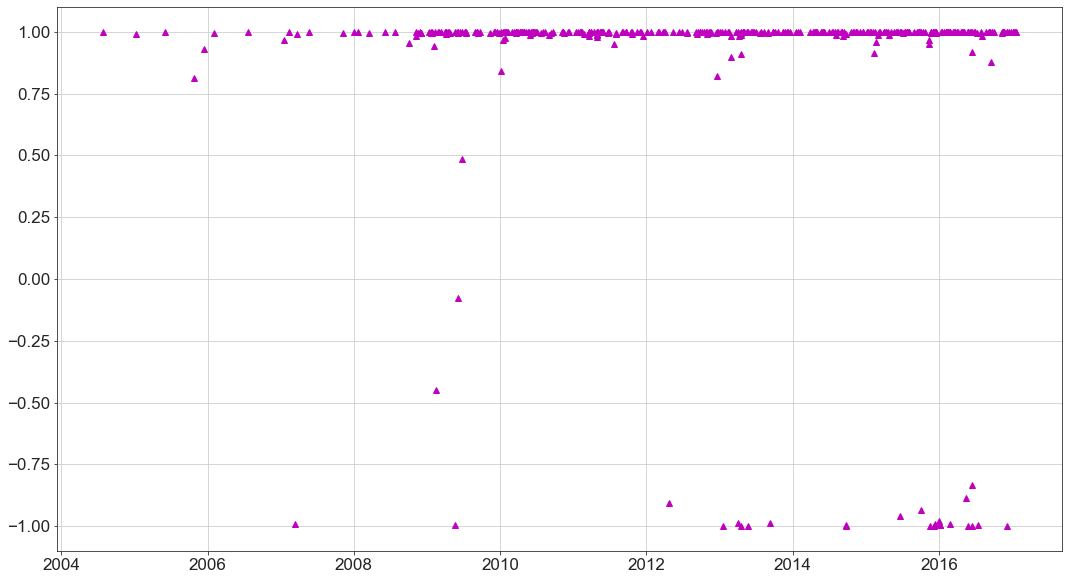

In [401]:
#Perhaps a more beneficial insight would be the distribution of Obama's speeches across time

df=data.copy(deep=True)
df.set_index('date',inplace=True,drop=True)
df.sort_index(inplace=True)

plt.figure(figsize=(18,10))
plt.plot(df['sentiment score'],c='m',marker='^',ls='',label='Score')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid()
plt.autoscale()

# Topic Modelling

In [375]:
#Adding some redundant words to stop words

new_stopwords=list(STOPWORDS)
new_stopwords.append('aammeerriiccaannrrhheettoorriicc')
new_stopwords.append('ccoomm')

In [377]:
#We will perform Count vectorisation using the CountVectorizer function in SKLearn

cv= CountVectorizer(max_df= 0.9, min_df=2, stop_words=new_stopwords)

In [378]:
#dtm is a mattrix that contains the frequency score for every word in the content present in the all the docs

dtm= cv.fit_transform(data['speech'])
dtm

C:\Users\manra\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<431x14966 sparse matrix of type '<class 'numpy.int64'>'
	with 334827 stored elements in Compressed Sparse Row format>

**Now we will try to find out the optimal number of topics in our Corpus. For this we will employ SVD on the text data:**

In [330]:
from sklearn.decomposition import TruncatedSVD

svd= TruncatedSVD(n_components=100, n_iter=30)
svd.fit(dtm)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=30,
             random_state=None, tol=0.0)

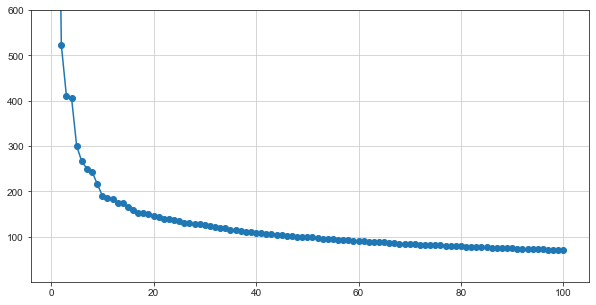

In [333]:
plt.figure(figsize=(10,5))
plt.plot(range(1,101), svd.singular_values_, marker='o')
plt.ylim(top=600)
plt.grid()
plt.show()

**From the above plot, it appears that taking number of topics= 10 might be a good Idea.**

**Now we will use LDA(Latent Dirichlet Allocation) technique provided in sklearn, to analyse these topics that appear in Obama's speeches:**

In [379]:
#As seen from the SVD graph, we provide 10 topics

lda= LatentDirichletAllocation(n_components=10)
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [380]:
#Getting the 10 highest probability words in the first topic

first_topic=lda.components_[0]
top_ten_words= first_topic.argsort()[-10:]
for i in top_ten_words:
    print(cv.get_feature_names()[i])

want
affordable
don
got
veterans
going
insurance
care
re
health


In [381]:
#grabbing highest probability words for each topic

for i,topic in enumerate(lda.components_):
    print('The top 10 words for topic:',i)
    print([cv.get_feature_names()[index] for index in topic.argsort()[-10:]])
    print('\n')

The top 10 words for topic: 0
['want', 'affordable', 'don', 'got', 'veterans', 'going', 'insurance', 'care', 're', 'health']


The top 10 words for topic: 1
['companies', 'crisis', 'need', 're', 'insurance', 'reform', 'financial', 'system', 'care', 'health']


The top 10 words for topic: 2
['world', 'state', 'palestinians', 'palestinian', 'states', 'united', 'must', 'security', 'peace', 'israel']


The top 10 words for topic: 3
['forces', 'nuclear', 'states', 'isil', 'iraq', 'war', 'military', 'united', 'security', 'world']


The top 10 words for topic: 4
['may', 'many', 'nation', 'faith', 'men', 'americans', 'life', 'day', 'america', 'god']


The top 10 words for topic: 5
['right', 'united', 'want', 'states', 'obama', 'question', 'going', 're', 'think', 'president']


The top 10 words for topic: 6
['every', 'rights', 'many', 're', 'must', 'states', 'united', 'new', 'america', 'world']


The top 10 words for topic: 7
['energy', 'years', 'businesses', 'year', 'tax', 'economy', 'new', 'a

**Based on the most probable words in the topics we can assign the following notation to topics:**

Topic 0 :  Affordable Insuarance and Healthcare for Veterans

Topic 1 :  Insuarance comapnies crisis, Financial system need reform

Topic 2 :  United States's role in peace and security in Israel/Palestine

Topic 3 :  ISIL and war in Iraq

Topic 4 :  Faith and God in America

Topic 5 :  Question Obama on Who's going to be President

Topic 6 :  Rights in America and World

Topic 7 :  Business and new jobs in America

Topic 8 :  President and Governor

Topic 9 :  Obama's deal with Iran's President

**Now we will assign topics to the articles in the dataframe, similar articles will be classified under similar topics**

In [383]:
#we will re transform the dtm matrix and get a matrix which gives us the probabilities of each word against being the topic of a particular speech

topic_results= lda.transform(dtm)

In [390]:
#We will assign a new category called topic to every speech made by Obama

data['topic']=topic_results.argmax(axis=1)
data.head()

,date,header,speech,sentiment score,sentiment of speech,topic
0,2016-04-01,Nuclear Security Summit Presser,I want to begin by thanking the people of Wa...,0.9999,Positive,9
1,2014-08-01,Presser on the Economy and Foreign Policy,Happy Friday. I thought I’d take some quest...,0.9999,Positive,9
2,2008-12-01,Security Team Announcement,I hope you all had a wonderful Thanksgiving. ...,0.9974,Positive,3
3,2009-12-01,Afghanistan War Troop Surge,All rights reserved. Page 1 Barack Obama ...,0.9979,Positive,3
4,2015-12-01,Paris Press Conference,"Once again, I want to thank the people of Fr...",1.0000,Positive,5
